In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
import pandas as pd
import itertools
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
tqdm.pandas()

# Summary

Face recognition models are regular convolutional neural networks models. They represent face photos as vectors. We find the distance between these two vectors to compare two faces. Finally, we classify two faces as same person whose distance is less than a threshold value.

The question is that how to determine the threshold. In this notebook, we will find the best split point for a threshold.

# 1. 동양인 데이터
- 같은 사람 3000 pairs, 다른 사람 3000 pairs

In [ ]:
df1 = pd.read_csv('/content/drive/My Drive/기업프로젝트-라젠/deepface/tests/pair_with_dist_l2.csv')
del df1['distance'], df1['distance_l2']
df1

,file_x,file_y,decision
0,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes
1,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes
2,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes
3,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes
4,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes
...,...,...,...
5995,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No
5996,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No
5997,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No
5998,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No


In [39]:
import os
os.getcwd()
os.chdir("/content/drive/My Drive/기업프로젝트-라젠/deepface/")

In [40]:
# !pip install mtcnn
from deepface import DeepFace

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa

instances = df1[["file_x", "file_y"]].values.tolist()
model_name = "resnet"
distance_metric = "euclidean_l2"
resp_obj = DeepFace.verify(instances, model_name = model_name, distance_metric = distance_metric, enforce_detection=False)

Using resnet_50-2 model backend and euclidean_l2 distance.


Verification: 100%|██████████| 6000/6000 [47:03<00:00,  2.12it/s]


In [ ]:
distances = []
for i in range(0, len(instances)):
    distance = round(resp_obj["pair_%s" % (i+1)]["distance"], 4)
    distances.append(distance)

In [ ]:
df1["distance_l2"] = distances

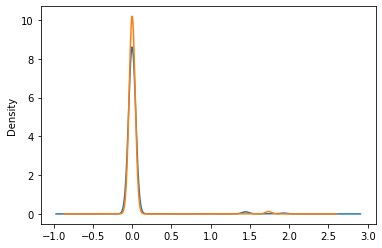

In [ ]:
df1[df1.decision == "Yes"].distance_l2.plot.kde()
df1[df1.decision == "No"].distance_l2.plot.kde()

In [ ]:
df1['distance_l2_scaled'] = -df1['distance_l2']

In [ ]:
df1

,file_x,file_y,decision,distance_l2,distance_l2_scaled
0,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes,0.0,-0.0
1,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes,0.0,-0.0
2,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes,0.0,-0.0
3,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes,0.0,-0.0
4,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes,0.0,-0.0
...,...,...,...,...,...
5995,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No,0.0,-0.0
5996,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No,0.0,-0.0
5997,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No,0.0,-0.0
5998,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No,0.0,-0.0


In [ ]:
df1.to_csv('/content/drive/My Drive/기업프로젝트-라젠/deepface/tests/outputs/pair_with_dist_Asian_6000_non_cropped_resnet.csv', index=False)

# ROC curve

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score

In [ ]:
encoder = LabelEncoder()
encoder.fit(df1['decision'])
df1['y'] = encoder.transform(df1['decision']) # 1='Yes' / 0='No'
df1['y']

0       1
1       1
2       1
3       1
4       1
       ..
5995    0
5996    0
5997    0
5998    0
5999    0
Name: y, Length: 6000, dtype: int64

In [ ]:
fpr, tpr, thresholds = roc_curve(df1['y'], df1['distance_l2_scaled'], pos_label=1)
roc_auc = auc(fpr, tpr)

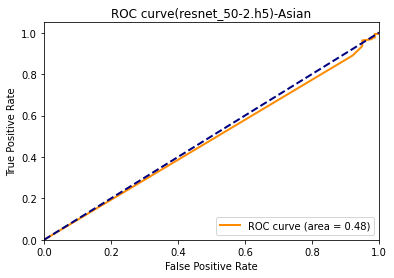

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve(resnet_50-2.h5)-Asian')
plt.legend(loc="lower right")
plt.show()

# threshold
- not using k-fold

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier

import graphviz
from sklearn.tree import export_graphviz

In [ ]:
clf1 = DecisionTreeClassifier(max_depth=1)
X = np.array(df1['distance_l2']).reshape(-1, 1)
y = np.array(df1['y']).reshape(-1, 1)
clf1.fit(X, y)
print(clf1.score(X, y))

0.5158333333333334


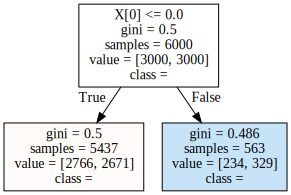

In [ ]:
export_graphviz(clf1, out_file='clf1.dot', class_names=['불일치', '일치'], impurity=True, filled=True)
with open('clf1.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [ ]:
threshold = clf1.tree_.threshold[0]

In [ ]:
df1["pred_euclidean_l2"] = "No"

idx = df1[df1.distance_l2 <= threshold].index
df1.loc[idx, 'pred_euclidean_l2'] = 'Yes'

In [ ]:
cm = confusion_matrix(df1.decision.values, df1.pred_euclidean_l2.values)
cm

array([[ 234, 2766],
       [ 329, 2671]])

In [ ]:
tn, fp, fn, tp = cm.ravel()
tn, fp, fn, tp

(234, 2766, 329, 2671)

In [ ]:
recall = tp / (tp + fn)
precision = tp / (tp + fp)
accuracy = (tp + tn)/(tn + fp +  fn + tp)
f1 = 2 * (precision * recall) / (precision + recall)

In [ ]:
print("Precision: ", 100*precision,"%")
print("Recall: ", 100*recall,"%")
print("F1 score ",100*f1, "%")
print("Accuracy: ", 100*accuracy,"%")

Precision:  49.1263564465698 %
Recall:  89.03333333333333 %
F1 score  63.316344672276884 %
Accuracy:  48.41666666666667 %


---

# 2. lfw 데이터

In [43]:
df2 = pd.read_csv('/content/drive/My Drive/기업프로젝트-라젠/deepface/tests/pair_with_dist_lfw.csv')
del df2['distance_l2']
df2

,file_x,file_y,decision
0,/content/drive/My Drive/main_proj/라젠/deepfa...,/content/drive/My Drive/main_proj/라젠/deepfa...,Yes
1,/content/drive/My Drive/main_proj/라젠/deepfa...,/content/drive/My Drive/main_proj/라젠/deepfa...,Yes
2,/content/drive/My Drive/main_proj/라젠/deepfa...,/content/drive/My Drive/main_proj/라젠/deepfa...,Yes
3,/content/drive/My Drive/main_proj/라젠/deepfa...,/content/drive/My Drive/main_proj/라젠/deepfa...,Yes
4,/content/drive/My Drive/main_proj/라젠/deepfa...,/content/drive/My Drive/main_proj/라젠/deepfa...,Yes
...,...,...,...
5995,/content/drive/My Drive/main_proj/라젠/deepfa...,/content/drive/My Drive/main_proj/라젠/deepfa...,No
5996,/content/drive/My Drive/main_proj/라젠/deepfa...,/content/drive/My Drive/main_proj/라젠/deepfa...,No
5997,/content/drive/My Drive/main_proj/라젠/deepfa...,/content/drive/My Drive/main_proj/라젠/deepfa...,No
5998,/content/drive/My Drive/main_proj/라젠/deepfa...,/content/drive/My Drive/main_proj/라젠/deepfa...,No


In [44]:
df2.iloc[0,0]
# /content/drive/My Drive/main_proj/라젠/deepface/tests/lfw_funneled_samples/ 
# -> /content/drive/My Drive/기업프로젝트-라젠/deepface/tests/lfw_funneled_samples/

'/content/drive/My Drive/main_proj/라젠/deepface/tests/lfw_funneled_samples/Ariel_Sharon/Ariel_Sharon_0075.jpg'

In [49]:
a = '/content/drive/My Drive/main_proj/라젠/deepface/tests/lfw_funneled_samples/'
b = '/content/drive/My Drive/기업프로젝트-라젠/deepface/tests/lfw_funneled_samples/'

df2['file_x'] = df2['file_x'].apply(lambda x: x.replace(a, b))
df2['file_y'] = df2['file_y'].apply(lambda x: x.replace(a, b))

In [50]:
import tensorflow as tf
import tensorflow_addons as tfa

instances = df2[["file_x", "file_y"]].values.tolist()
model_name = "resnet"
distance_metric = "euclidean_l2"
resp_obj = DeepFace.verify(instances, model_name = model_name, distance_metric = distance_metric, enforce_detection=False)
# 1시간 걸림(6000 pairs)

Using resnet_50-2 model backend and euclidean_l2 distance.


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.

Verification:  72%|███████▏  | 4334/6000 [21:21<05:42,  4.86it/s]


Verification:  72%|███████▏  | 4335/6000 [21:22<05:42,  4.86it/s]


Verification:  72%|███████▏  | 4336/6000 [21:22<05:40,  4.89it/s]


Verification:  72%|███████▏  | 4337/6000 [21:22<05:43,  4.84it/s]


Verification:  72%|███████▏  | 4338/6000 [21:22<05:44,  4.83it/s]


Verification:  72%|███████▏  | 4339/6000 [21:23<05:36,  4.94it/s]


Verification:  72%|███████▏  | 4340/6000 [21:23<05:34,  4.96it/s]


Verification:  72%|███████▏  | 4341/6000 [21:23<05:36,  4.93it/s]


Verification:  72%|███████▏  | 4342/6000 [21:23<05:36,  4.93it/s]


Verification:  72%|███████▏  | 4343/6000 [21:23<05:31,  5.00it/s]


Verification:  72%|███████▏  | 4344/6000 [21:24<05:31,  4.99it/s]


Verification:  72%|███████▏  | 4345/6000 [21:24<05:30,  5.01it/s]


Verification:  72%|███████▏  | 4346/6000 [21:24<05:28,  5.03it/s]


Verification:  72%|███████▏  | 4347/6000 [21:24<05:28,  5.03it/s]


Verificatio

In [51]:
distances = []
for i in range(0, len(instances)):
    distance = round(resp_obj["pair_%s" % (i+1)]["distance"], 4)
    distances.append(distance)
df2["distance_l2"] = distances

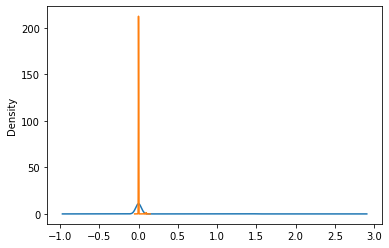

In [52]:
df2[df2.decision == "Yes"].distance_l2.plot.kde()
df2[df2.decision == "No"].distance_l2.plot.kde()

In [53]:
df2.to_csv('/content/drive/My Drive/기업프로젝트-라젠/deepface/tests/outputs/pair_with_dist_lfw_6000_non_cropped_resent.csv', index=False)

# ROC curve

In [54]:
df2['distance_l2_scaled'] = -df2['distance_l2']

In [55]:
encoder = LabelEncoder()
encoder.fit(df2['decision'])
df2['y'] = encoder.transform(df2['decision']) # 1='Yes' / 0='No'
df2['y']

0       1
1       1
2       1
3       1
4       1
       ..
5995    0
5996    0
5997    0
5998    0
5999    0
Name: y, Length: 6000, dtype: int64

In [56]:
fpr, tpr, thresholds = roc_curve(df2['y'], df2['distance_l2_scaled'], pos_label=1)
roc_auc = auc(fpr, tpr)

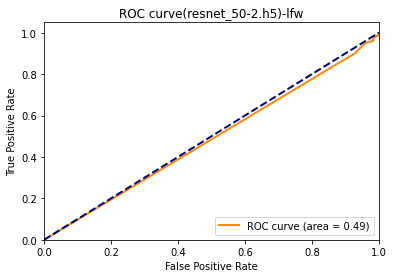

In [57]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve(resnet_50-2.h5)-lfw')
plt.legend(loc="lower right")
plt.show()

# Threshold

In [62]:
clf2 = DecisionTreeClassifier(max_depth=1)
X = np.array(df2['distance_l2']).reshape(-1, 1)
y = np.array(df2['y']).reshape(-1, 1)
clf2.fit(X, y)
print(clf2.score(X, y))

0.5068333333333334


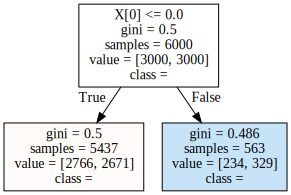

In [63]:
export_graphviz(clf1, out_file='clf2.dot', class_names=['불일치', '일치'], impurity=True, filled=True)
with open('clf2.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [64]:
threshold = clf2.tree_.threshold[0]

In [65]:
df2["pred_euclidean_l2"] = "No"

idx = df2[df2.distance_l2 <= threshold].index
df2.loc[idx, 'pred_euclidean_l2'] = 'Yes'

In [66]:
df2.sample(5)

,file_x,file_y,decision,distance_l2,distance_l2_scaled,y,pred_euclidean_l2
5955,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No,0.0,-0.0,0,Yes
1166,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes,0.0,-0.0,1,Yes
3542,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No,0.0,-0.0,0,Yes
2963,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes,0.0,-0.0,1,Yes
5493,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No,0.0,-0.0,0,Yes


In [67]:
cm = confusion_matrix(df2.decision.values, df2.pred_euclidean_l2.values)
cm

array([[   0, 3000],
       [  41, 2959]])

In [68]:
tn, fp, fn, tp = cm.ravel()
tn, fp, fn, tp 

(0, 3000, 41, 2959)

In [69]:
recall = tp / (tp + fn)
precision = tp / (tp + fp)
accuracy = (tp + tn)/(tn + fp +  fn + tp)
f1 = 2 * (precision * recall) / (precision + recall)

print("Precision: ", 100*precision,"%")
print("Recall: ", 100*recall,"%")
print("F1 score ",100*f1, "%")
print("Accuracy: ", 100*accuracy,"%")

Precision:  49.655982547407284 %
Recall:  98.63333333333333 %
F1 score  66.05647951780333 %
Accuracy:  49.31666666666666 %
